In [83]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

        

In [84]:
class Layer(object):
    def compute(self, x):
        raise NotImplemented()

    # Returns a maybe-empty matrix that contains all the parameters of the layer.
    def params(self):
        return self._params
    
    def dcostdx(self, x, y, dcostdy):
        raise NotImplemented()
        
    def dcostdparams(self, x, y, dcostdy):
        return np.array([])
        
    def update_params(self, gradients):
        if len(gradients.shape) == 1:
            gradients.shape = self._params.shape
        if gradients.shape != self._params.shape:
            raise Exception("Gradients should be the same size as the parameters")
        self._params -= gradients

class Network(object):
    def __init__(self, layers, cost_function):
        self._layers = layers
        self._cost_function = cost_function
        
    def compute(self, x):
        for layer in self._layers:
            x = layer.compute(x)
            
        return x
    
    def compute_single_cost(self, x, y):
        y_ = self.compute(x)
        return self._cost_function.compute(y, y_)
    
    def compute_cost(self, X, y):
        y_ = self.compute(X)
        cost = self._cost_function.compute(y, y_)
        assert cost.shape[0] == len(y)
        return np.sum(cost) / len(y)
    
    def backprop_gradients(self, x, y):
        results = [x]
        for layer in self._layers:
            x = layer.compute(x)
            results.append(x)

        gradients = []
        
        dcostdy = self._cost_function.dcostdy(y, x)
        for layer in reversed(self._layers):
            gradients.append(layer.dcostdparams(results[-2], results[-1], dcostdy))
            dcostdy = layer.dcostdx(results[-2], results[-1], dcostdy)
            results.pop()
            
        gradients.reverse()
        return gradients
    
    def numeric_gradients(self, X, y):
        "This is wrong. I don't know how, but it is wrong."
        epsilon = 0.0000001
        gradients = []
        for layer in self._layers:
            params = layer.params().reshape(layer.params().size)
            layer_gradients = np.zeros(params.size)
            gradients.append(layer_gradients)
            for i in range(len(params)):
                params[i] += epsilon
                high = self.compute_cost(X, y)
                params[i] -= 2*epsilon
                low = self.compute_cost(X, y)
                params[i] += epsilon
                layer_gradients[i] = (high-low)/epsilon
        return gradients
    
    def update_params(self, gradients):
        for i, layer in enumerate(self._layers):
            layer.update_params(gradients[i])
                
    def __repr__(self):
        return '<Network: (layers=%s, cost_function=%s)>' % (str(self._layers), str(self._cost_function))

In [163]:
# Inputs and outputs are column vectors

class LinearLayer(Layer):
    def __init__(self, input_size, output_size):
        # +1 for the bias.
        params = 2 * (np.random.rand(input_size + 1, output_size) - 0.5) / np.sqrt(input_size)
        self._params = np.round(params, decimals=2)
        
    def dcostdx(self, x, y, dcostdy):
        return dcostdy.dot(self._params.T)[:, 1:]
    
    def dcostdparams(self, x, y, dcostdy):
        # Accept 1-d arrays
        if len(x.shape) < 2:
            x.shape = (1, x.shape[0])

        x = np.hstack((np.ones(shape=(x.shape[0], 1)), x))
        return x.T.dot(dcostdy)
    
    def compute(self, x):
        # Accept 1-d arrays
        if len(x.shape) < 2:
            x.shape = (1, x.shape[0])

        x = np.hstack((np.ones(shape=(x.shape[0], 1)), x))
        ret = x.dot(self._params)
        return ret
    
    def __repr__(self):
        return 'Linear(%s, %s)' % (self._params.shape[1]-1, self._params.shape[0])
    
from scipy.special import expit

class SigmoidLayer(Layer):
    def __init__(self):
        self._params = np.array([])
        
    def dcostdx(self, x, y, dcostdy):
        return dcostdy * (y * (1-y))
        
    def compute(self, x):
        return expit(x)
    
    def __repr__(self):
        return 'Sigmoid'
sigmoidLayer = SigmoidLayer()

class LogisticCost(object):
    def dcostdy(self, y, y_):
        return (y_ - y) / (y_ * (1-y_))
        
    def compute(self, y, y_):
        "y is the actual value, y_ is the predicted value."
        epsilon = np.finfo('float64').eps
        y_ = np.clip(y_, epsilon, 1.0 - epsilon)
        cost = -y * np.log(y_) - (1-y) * np.log(1-y_)
        return np.sum(cost, axis=1)
    
    def __repr__(self):
        return 'LogisticCostFunction'
logisticCost = LogisticCost()

In [164]:
def NewNeuralNet(*args):
    layers = []
    for i in range(len(args)-1):
        layers.append(LinearLayer(args[i], args[i+1]))
        layers.append(sigmoidLayer)

    return Network(layers, logisticCost)

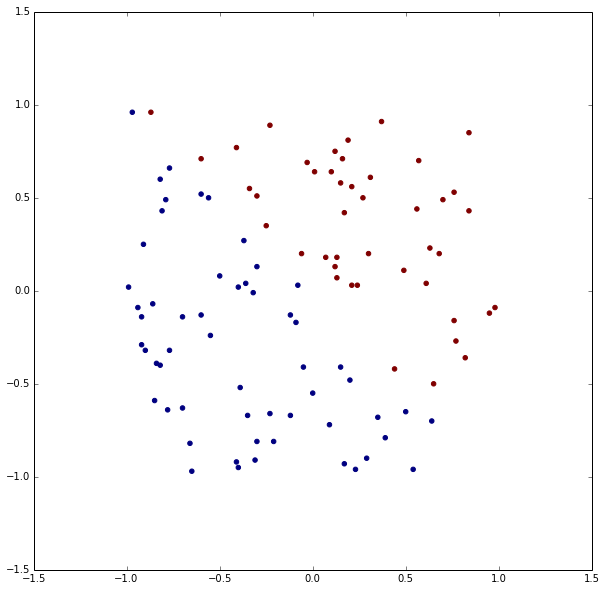

In [165]:
# Now we generate some synthetic data
np.random.seed(10)

N = 100
X = np.round(np.random.rand(N, 2) * 2 - 1, decimals=2)
y = np.zeros((N, 1))

for i, x in enumerate(X):
    if np.sum(x) > 0:
        y[i][0] = 1
        
np.sum(y, axis=0)


X.reshape(X.size)
X.shape
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=y[:, 0], edgecolors='face')

In [166]:
np.random.seed(10)
nn = NewNeuralNet(2, 1)

np.random.seed(20)
#print(nn.compute_cost(X, y))

x_sample = X[0].reshape(1, 2)
y_sample = y[0]

backprop_gradients = nn.backprop_gradients(x_sample, y_sample)
print("backprop_gradients", backprop_gradients)

#print("numeric_gradients", nn.numeric_gradients(x_sample, y_sample))

print("params", nn._layers[0].params())
print("x_sample", x_sample)
print(nn.compute(x_sample))

original_cost = nn.compute_cost(x_sample, y_sample)
print(original_cost)

d = 0.0001
nn._layers[0]._params[0][0] += d
n0_cost = nn.compute_cost(x_sample, y_sample)
nn._layers[0]._params[0][0] -= d

nn._layers[0]._params[1][0] += d
n1_cost = nn.compute_cost(x_sample, y_sample)
nn._layers[0]._params[1][0] -= d

nn._layers[0]._params[2][0] += d
n2_cost = nn.compute_cost(x_sample, y_sample)
nn._layers[0]._params[2][0] -= d

print(n0_cost - original_cost, n1_cost-original_cost, n2_cost-original_cost)


('backprop_gradients', [array([[ 0.45770134],
       [ 0.24715872],
       [-0.43939329]]), array([], dtype=float64)])
('params', array([[ 0.38],
       [-0.68],
       [ 0.19]]))
('x_sample', array([[ 0.54, -0.96]]))
[[ 0.45770134]]
0.611938399551
(4.5771375245085011e-05, 2.4716234353183708e-05, -4.3938185067537994e-05)


In [206]:
np.random.seed(10)

nn = NewNeuralNet(2, 3, 1)
print(nn.compute_cost(X, y))
print(X.shape)
learning_rate = 0.1
np.random.seed(20)
for i in xrange(1000):
    sample_i = np.random.randint(0, len(y))
    x_sample = X[sample_i]
    y_sample = y[sample_i]
    gradients = nn.backprop_gradients(x_sample, y_sample)
    gradients[0] *= learning_rate
    nn.update_params(gradients)
    
print(nn.compute_cost(X, y))

0.668575734234
(100, 2)
0.0577997114313
